Imports

In [1]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import scipy.stats as stats

import pcshrink

Read in the data

In [2]:
%%time
data = pcshrink.UnpackedAncestryMap("/project/jnovembre/jhmarcus/ancient-sardinia/data/ref_genotypes/7-11-2018/lazaridis_2014/data_fil")

CPU times: user 7.52 s, sys: 2.21 s, total: 9.73 s
Wall time: 3.91 s


In [3]:
print(data.n, data.p)

777 594924


Find snps that are too rare or too common

In [64]:
f = np.nansum(data.Y, axis=1) / (2. * data.n)
snp_idx = np.where((f > .05) & (f < .95))[0]
print(f.shape, snp_idx.shape)

(594924,) (391417,)


Mean center and scale and impute missing values to 0

In [66]:
Z = data.Y[snp_idx, :]

mu = np.nanmean(Z, axis=1).reshape(len(snp_idx), 1)
std = np.nanstd(Z, axis=1).reshape(len(snp_idx), 1)
het = np.sqrt(2. * f[snp_idx] * (1. - f[snp_idx])).reshape(len(snp_idx), 1)

Z = (Z - mu) / het
Z[np.isnan(Z)] = 0.0

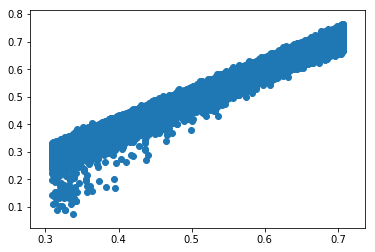

In [67]:
plt.scatter(het, std)

Run PCA on the original dataset

In [68]:
%%time
pca = PCA(20, svd_solver="full")
pca.fit(Z.T)

CPU times: user 2min 16s, sys: 13 s, total: 2min 29s
Wall time: 8.05 s


In [85]:
pca.singular_values_**2 / np.sum(pca.singular_values_**2)

array([0.19483185, 0.0893572 , 0.06821097, 0.05159962, 0.04830065,
       0.04355943, 0.0410076 , 0.03974637, 0.03923142, 0.03762263,
       0.03679093, 0.03631968, 0.03600083, 0.03510952, 0.03425192,
       0.03403273, 0.03364398, 0.03357579, 0.03350829, 0.03329853],
      dtype=float32)

In [69]:
F_hat = pca.components_.T
F_hat.shape

(391417, 20)

In [79]:
L = (F_hat.T @ Z).T 
L = L / np.linalg.norm(L, axis=0, ord=2)

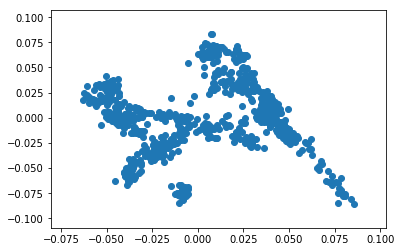

In [80]:
plt.scatter(L[:, 0], -L[:, 1])

See how fast the EM is ...

In [18]:
%%time
idx = np.ones(Z.shape[1], dtype="bool")
idx[0] = False
pcem = pcshrink.PCEM(Z[:, idx], F_hat)
pcem.run(eps=1e-5, max_iter=100)

1 16836.205 inf
2 16832.508 3.6972656
3 16829.775 2.7324219
4 16827.719 2.0566406
5 16826.125 1.59375
6 16824.879 1.2460938
7 16823.879 1.0
8 16823.06 0.8183594
9 16822.383 0.6777344
10 16821.807 0.5761719
11 16821.322 0.484375
12 16820.904 0.41796875
13 16820.543 0.36132812
14 16820.223 0.3203125
15 16819.94 0.28320312
16 16819.688 0.25195312
17 16819.463 0.22460938
18 16819.266 0.19726562
19 16819.086 0.1796875
20 16818.92 0.16601562
21 16818.77 0.15039062
22 16818.633 0.13671875
23 16818.508 0.125
24 16818.395 0.11328125
25 16818.287 0.107421875
26 16818.186 0.1015625
27 16818.1 0.0859375
28 16818.014 0.0859375
29 16817.934 0.080078125
30 16817.86 0.07421875
31 16817.793 0.06640625
32 16817.729 0.064453125
33 16817.67 0.05859375
34 16817.611 0.05859375
35 16817.557 0.0546875
36 16817.508 0.048828125
37 16817.457 0.05078125
38 16817.414 0.04296875
39 16817.37 0.044921875
40 16817.33 0.0390625
41 16817.291 0.0390625
42 16817.256 0.03515625
43 16817.219 0.037109375
44 16817.186 0.03320

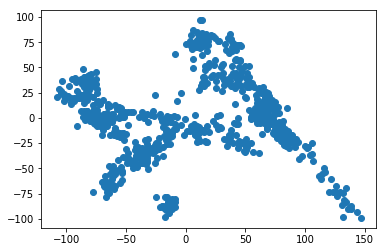

In [19]:
plt.scatter(pcem.L[:,0], -pcem.L[:,1])

In [20]:
l = Z[:, 0] @ pcem.F

Text(0,0.5,'l_proj')

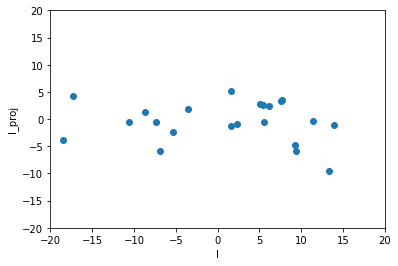

In [21]:
plt.scatter(L[0, :], l)
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.xlabel("l")
plt.ylabel("l_proj")